First few rows of training data:
   Unnamed: 0                Time  Location  Temp_2m  RelHum_2m      DP_2m  \
0           0 2013-01-02 00:00:00         1  28.2796  84.664205  24.072595   
1           1 2013-01-02 01:00:00         1  28.1796  85.664205  24.272595   
2           2 2013-01-02 02:00:00         1  26.5796  90.664205  24.072595   
3           3 2013-01-02 03:00:00         1  27.1796  87.664205  23.872595   
4           4 2013-01-02 04:00:00         1  27.0796  87.664205  23.672595   

     WS_10m   WS_100m      WD_10m     WD_100m    WG_10m     Power  
0  1.605389  1.267799  145.051683  161.057315  1.336515  0.163496  
1  2.225389  3.997799  150.051683  157.057315  4.336515  0.142396  
2  1.465389  2.787799  147.051683  149.057315  3.136515  0.121396  
3  1.465389  2.697799   57.051683  104.057315  1.536515  0.100296  
4  2.635389  4.437799   57.051683   83.057315  3.936515  0.079296  


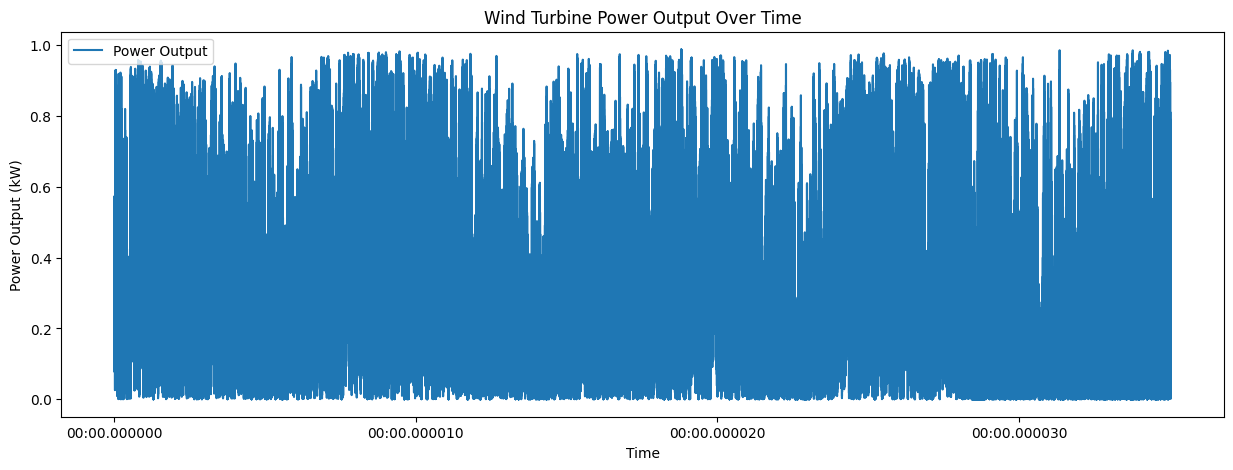

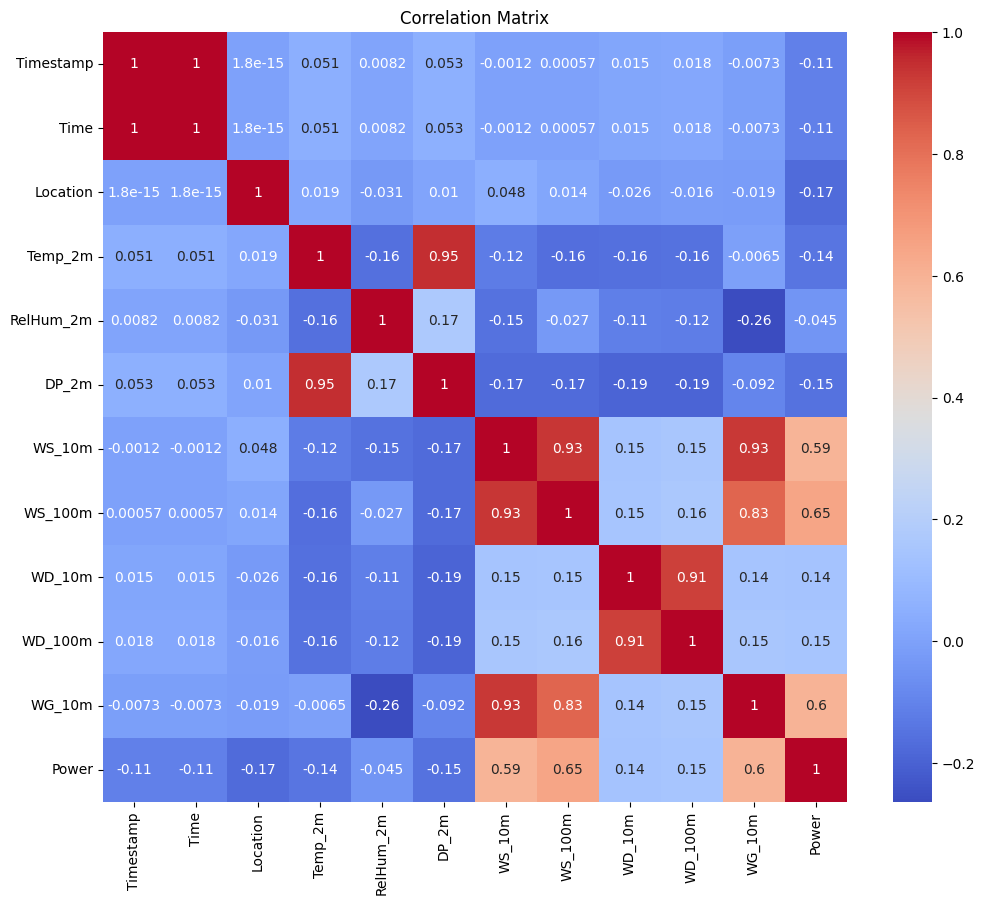

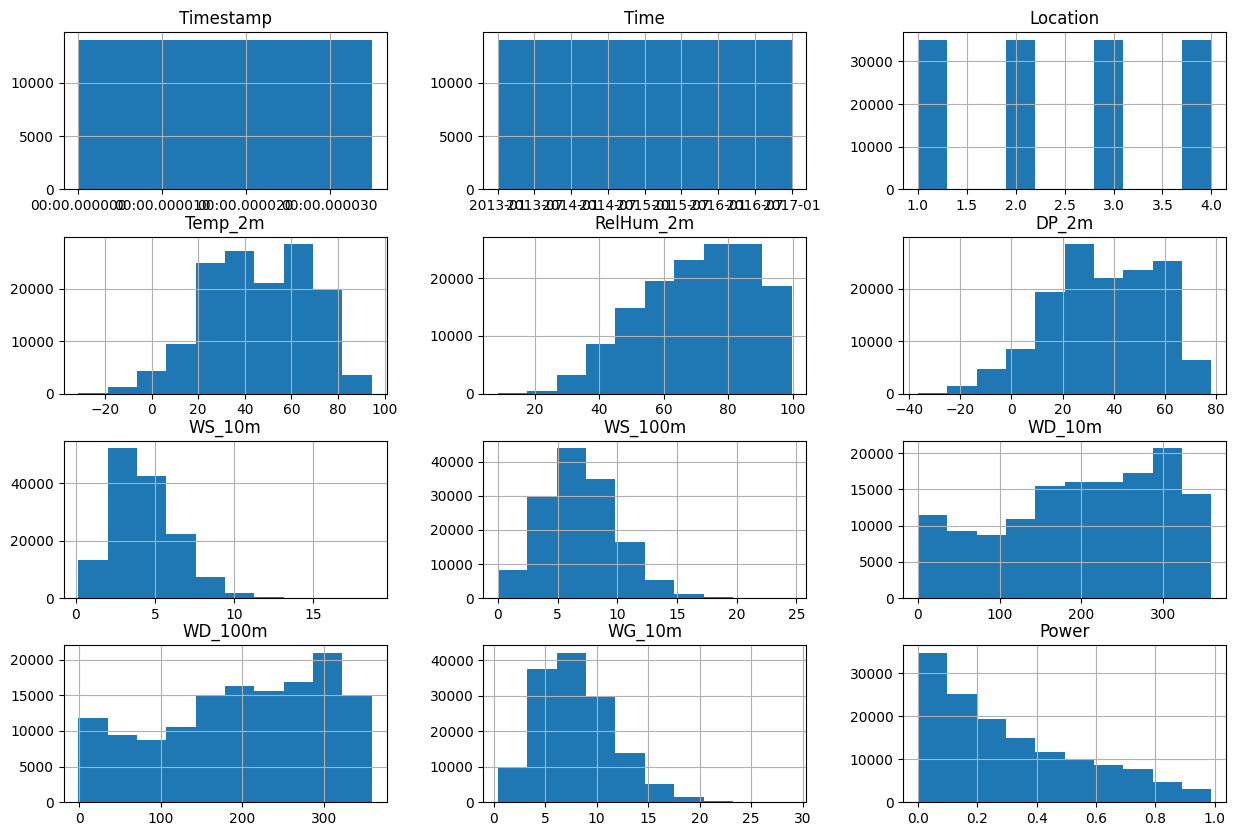

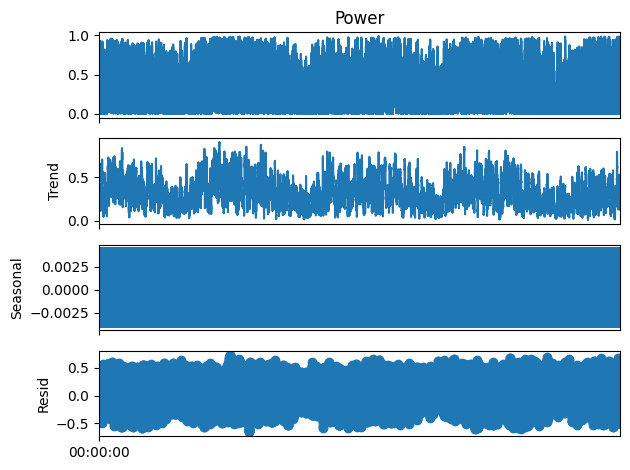

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validated RMSE Scores: [0.01406652 0.00635457 0.00935257 0.01255221 0.00618039]
Average RMSE: 0.009701251934473028


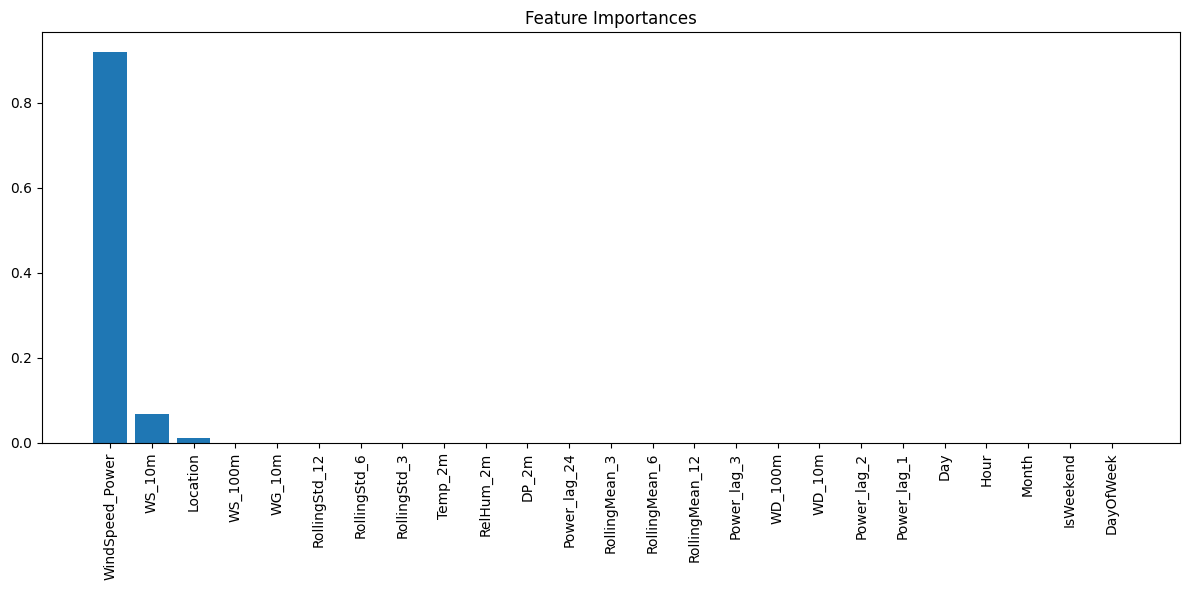

Predictions added to test_df.
'Predicted_Power' successfully added to test_df.
Submission file 'Submission.csv' has been created.
Model training and prediction completed successfully.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# For time series decomposition
import statsmodels.api as sm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Data Loading and Preparation
# ------------------------------

# Load training data
train_df = pd.read_excel('Train.xlsx')

# Load test data
test_df = pd.read_csv('Test.csv')

# Display first few rows of the training data
print("First few rows of training data:")
print(train_df.head())

# Ensure 'Timestamp' column is correctly read
if 'Unnamed: 0' in train_df.columns:
    train_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
if 'Unnamed: 0' in test_df.columns:
    test_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)

# Convert 'Timestamp' to datetime
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# Sort training data by 'Timestamp'
train_df.sort_values('Timestamp', inplace=True)
train_df.reset_index(drop=True, inplace=True)

# ------------------------------
# 2. Exploratory Data Analysis (EDA)
# ------------------------------

# Plot Power Output Over Time
plt.figure(figsize=(15,5))
plt.plot(train_df['Timestamp'], train_df['Power'], label='Power Output')
plt.xlabel('Time')
plt.ylabel('Power Output (kW)')
plt.title('Wind Turbine Power Output Over Time')
plt.legend()
plt.show()

# Correlation Matrix
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of Features
train_df.hist(figsize=(15,10))
plt.show()

# Decompose Time Series
power_ts = train_df.set_index('Timestamp')['Power']
decomposition = sm.tsa.seasonal_decompose(power_ts, model='additive', period=24)
fig = decomposition.plot()
plt.show()

# ------------------------------
# 3. Data Preprocessing
# ------------------------------

# Handle missing values by dropping (assuming few missing values)
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)

# ------------------------------
# 4. Feature Engineering
# ------------------------------

# Create time-based features
for df in [train_df, test_df]:
    df['Hour'] = df['Timestamp'].dt.hour
    df['Day'] = df['Timestamp'].dt.day
    df['Month'] = df['Timestamp'].dt.month
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Create lag features in training data
lags = [1, 2, 3, 24]  # Lags in hours
for lag in lags:
    train_df[f'Power_lag_{lag}'] = train_df['Power'].shift(lag)

# Drop rows with NaN values resulting from lag features
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)

# Create rolling statistics in training data
window_sizes = [3, 6, 12]  # Window sizes in hours
for window in window_sizes:
    train_df[f'RollingMean_{window}'] = train_df['Power'].rolling(window=window).mean()
    train_df[f'RollingStd_{window}'] = train_df['Power'].rolling(window=window).std()

# Drop NaN values from rolling statistics
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)

# Create interaction feature
if 'WS_10m' in train_df.columns:
    train_df['WindSpeed_Power'] = train_df['WS_10m'] * train_df['Power']
else:
    print("'WS_10m' not found in train_df.")

# ------------------------------
# 5. Prepare Training Data
# ------------------------------

# Define target variable
target = 'Power'

# Exclude 'Timestamp' and target from features
features = train_df.columns.drop(['Timestamp', target])

# Ensure all features are numeric
X_train = train_df[features].select_dtypes(include=[np.number])
y_train = train_df[target]

# Handle missing and infinite values in training data
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
y_train.fillna(y_train.mean(), inplace=True)

# ------------------------------
# 6. Model Training
# ------------------------------

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Initialize GridSearchCV with RandomForestRegressor
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# ------------------------------
# 7. Model Evaluation
# ------------------------------

# Cross-validated RMSE scores
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    grid_search.best_estimator_,
    X_train,
    y_train,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validated RMSE Scores:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())

# Feature Importances
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# ------------------------------
# 8. Prepare Test Data for Prediction
# ------------------------------

# Apply the same feature engineering steps to test_df

# Create lag features in test data using last known 'Power' values from train_df
last_power_values = train_df['Power'].iloc[-max(lags):].values
for lag in lags:
    test_df[f'Power_lag_{lag}'] = last_power_values[-lag]

# Create rolling statistics in test data using last known values from train_df
for window in window_sizes:
    rolling_mean = train_df[f'RollingMean_{window}'].iloc[-1]
    rolling_std = train_df[f'RollingStd_{window}'].iloc[-1]
    test_df[f'RollingMean_{window}'] = rolling_mean
    test_df[f'RollingStd_{window}'] = rolling_std

# Create interaction feature in test data
if 'WS_10m' in test_df.columns:
    last_power = train_df['Power'].iloc[-1]
    test_df['WindSpeed_Power'] = test_df['WS_10m'] * last_power
else:
    print("'WS_10m' not found in test_df.")

# Ensure features are consistent between train and test data
features = [feature for feature in features if feature in test_df.columns]

# Prepare X_test
X_test = test_df[features].select_dtypes(include=[np.number])

# Handle missing and infinite values in test data
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(method='ffill', inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# ------------------------------
# 9. Make Predictions on Test Data
# ------------------------------

# Make predictions
try:
    test_df['Predicted_Power'] = grid_search.best_estimator_.predict(X_test)
    print("Predictions added to test_df.")
except Exception as e:
    print("Error during prediction:", e)

# Verify that 'Predicted_Power' is in test_df
if 'Predicted_Power' in test_df.columns:
    print("'Predicted_Power' successfully added to test_df.")
else:
    print("'Predicted_Power' not found in test_df.")

# ------------------------------
# 10. Prepare Submission File
# ------------------------------

# Prepare the submission DataFrame
submission_df = test_df[['Timestamp', 'Predicted_Power']].copy()
submission_df.rename(columns={'Timestamp': 'Timestamp', 'Predicted_Power': 'Power'}, inplace=True)

# Save to CSV
submission_df.to_csv('Submission.csv', index=False)
print("Submission file 'Submission.csv' has been created.")

# ------------------------------
# 11. Conclusion
# ------------------------------

print("Model training and prediction completed successfully.")


In [2]:
submission_df.to_csv('Submission.csv', index=False)
print("Submission file 'Submission.csv' has been created.")

Submission file 'Submission.csv' has been created.


In [3]:
import pandas as pd

# Specify the path to your CSV file
file_path = 'Submission.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print("First few rows of the CSV file:")
print(df.head())

# Display information about the DataFrame (optional)
print("\nInformation about the CSV file:")
print(df.info())

# Display summary statistics (optional)
print("\nSummary statistics of the CSV file:")
print(df.describe())


First few rows of the CSV file:
                       Timestamp     Power
0  1970-01-01 00:00:00.000035040  0.163160
1  1970-01-01 00:00:00.000035041  0.169500
2  1970-01-01 00:00:00.000035042  0.164882
3  1970-01-01 00:00:00.000035043  0.165365
4  1970-01-01 00:00:00.000035044  0.166963

Information about the CSV file:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  35040 non-null  object 
 1   Power      35040 non-null  float64
dtypes: float64(1), object(1)
memory usage: 547.6+ KB
None

Summary statistics of the CSV file:
              Power
count  35040.000000
mean       0.167637
std        0.004151
min        0.102792
25%        0.165494
50%        0.167382
75%        0.169045
max        0.243378
